In [6]:
from feilian import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics
import netCDF4 as nc
import seaborn as sns

# Put this notebook on the git repo feilian root directory
# The structure of the directory should look like the following:
# .
# ├── feilian
# │   ├── data_formatter.py
# │   ├── __init__.py
# │   └── neural_network.py
# ├── models
# │   └── feilian_net_20250609T20:00:32.pth
# |   └── feilian_net_20250211T15-20-30_1200all.pth
# ├── feilian-demo.ipynb
# └── raw_data
#     ├── pedestrian (Pedestrian level wind speed)
#     │   ├── *_ped.nc file downloadable from https://urbantales.climate-resilientcities.com/
#     └── topo (2D building height in ASCII form)
#         ├── *_topo file downloadable from https://urbantales.climate-resilientcities.com/
# where models folder stores the trained model parameters, raw_data folder stores topo and les results

In [123]:
def read_topo(case_name):
    topo_fmt = "raw_data/topo/{}_topo"
    topo_name = topo_fmt.format(case_name[1:] if "R" == case_name[0] else case_name)
    df = pd.read_csv(topo_name, header=None, sep="\r")
    topo = []
    for i in range(np.shape(df.values)[0]):
        cc = df.values[i][0].split()
        cc = np.squeeze([np.float32(x) for x in cc])
        topo.append(cc)
    topo_arr = np.array(topo, dtype=np.float32)
    if "R" == case_name[0]:
        topo_arr = topo_arr.T
    return topo_arr

def read_les_result(case_name):
    les_fmt = "raw_data/pedestrian/{}_ped.nc"
    data_name = les_fmt.format(case_name)
    udata = np.flip(nc.Dataset(data_name).variables['Uped'][:].data, 0)
    if "R" == case_name[0]:
        udata = udata.T
    return udata

def plot_comparison(case_name, case_topo, truth, pred, windangle):
    if windangle >= 90 and windangle < 180:
        pred = np.transpose(np.flip(prediction,axis=0))
    if windangle >= 180 and windangle < 270:
        pred = np.rot90(pred, k=2)
    if windangle >= 270 and windangle < 360:
        pred = np.rot90(pred, k=1)
    vmin_percentile = 2
    vmax_percentile = 99 # remove anomalies in prediction 
    
    combined = np.concatenate([truth[~np.isnan(truth)], pred[~np.isnan(pred)]])
    
    #vmin = np.percentile(combined, vmin_percentile)
    vmax = np.percentile(combined, vmax_percentile)
    vmin = 0
    
    pred[np.isnan(truth)] = np.nan

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    pc1 = axes[0].imshow(case_topo, cmap="gray_r", alpha=0.5)
    cbar = fig.colorbar(pc1, ax=axes, shrink=0.3)
    cbar.set_label("Building height [m]", fontsize=10)

    
    
    
    pc2 = axes[0].imshow(truth, cmap="jet",vmin=vmin,vmax=vmax)
    
    axes[0].set_title(f"LES Reference ({case_name})", fontsize=12)

    cbar = fig.colorbar(pc2, ax=axes.ravel().tolist(), shrink=0.6, orientation="horizontal")
    cbar.set_label("Wind speed [m/s]", fontsize=10)


    #fig.colorbar(pc2, ax=axes, shrink=0.4)
    axes[1].imshow(case_topo, cmap="gray_r", alpha=0.5)
    axes[1].imshow(pred, cmap="jet",vmin=vmin,vmax=vmax)
    
    #r2score = round(skmetrics.r2_score(truth[~np.isnan(truth)], pred[~np.isnan(pred)]), 2)
    axes[1].set_title(f"U-Net Prediction)", fontsize=12)

In [141]:
# load trained model parameters to the model
model = FeilianNet(chan_multi=16, max_level=6, activation=nn.ReLU(True))
check_point = torch.load("models/feilian_net_20250609T20:00:32.pth", map_location=torch.device('cpu'))
#check_point = torch.load("models/feilian_net_20250211T15-20-30_1200all.pth", map_location=torch.device('cpu'))
check_point = {k.replace('module.', ''): v for k, v in check_point.items()}
model.load_state_dict(check_point)

<All keys matched successfully>

In [142]:
# Load the raw data of topo and les simulation results
casename, windangle = "m1", 0 #  0 <= wind angle < 360
topo, lesres = read_topo(casename), read_les_result(casename)

In [143]:
# format the raw data so that it can be used as model input
# `DataFormatter` takes in three arguments: topo, wind angle, and format size
# Make sure elements in topo are all negative
# If not specificed, default wind angle is zero
# format size depends on the format size used during the training of the model
dfmt = DataFormatter([-topo], [windangle], 1280)
fmt_input = torch.tensor(dfmt.get_formatted_input_data())
fmt_output = model(fmt_input).detach().cpu().numpy()
prediction = dfmt.restore_raw_output_data(fmt_output)[0]

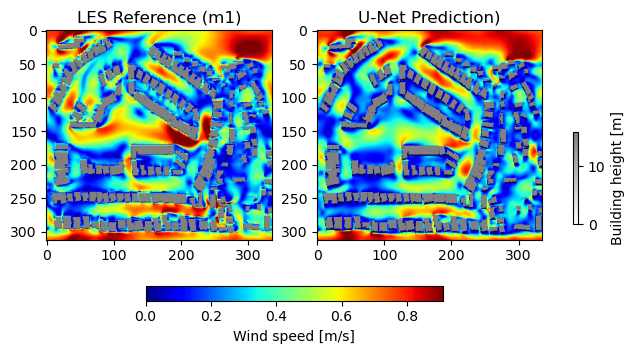

In [144]:
plot_comparison(casename, topo, lesres, prediction, windangle)